In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Gene Nodes

Putting together the Information for the nodes and save them as a csv file.

Nodes are genes with the following information:
- Gene ID
- Gene Name
- TPM value for lung cancer
- TPM value for healthy lung tissue
- TMP difference between cancer and healthy tissue

In [2]:
df_gtex = pd.read_csv('../processed_data/GTEX_healthy_mean.csv', usecols=['Gene ID', 'healthy TPM'])
df_cmp = pd.read_csv('../processed_data/CMP_cancer_mean.csv')

df_protein_gene = pd.read_csv('../import_data/ENSEMBLE/biomart_gene_protein.txt',  sep='\t')

plt.figure(figsize=(20, 5))

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

## List of genes that have a gene-protein connection

In [3]:
df_protein_gene = df_protein_gene[df_protein_gene['Protein stable ID'].notna()]
protein_genes = df_protein_gene['Gene stable ID'].unique()

len(protein_genes)

23837

## Merge CMP (cancer) and GTEx (healthy) dataset

In [4]:
df_nodes_cancer = df_cmp.copy()
df_nodes_healthy = df_gtex.copy()

df_nodes_genes = df_nodes_cancer.merge(df_nodes_healthy, on='Gene ID', how='inner')

# filter out those without gene-protein connection
df_nodes_genes = df_nodes_genes[df_nodes_genes['Gene ID'].isin(protein_genes)]

print(f"There are {df_nodes_genes.shape[0]} rows in the merged dataset. All have a healthy and a cancer TPM value.")

df_nodes_genes

There are 17626 rows in the merged dataset. All have a healthy and a cancer TPM value.


,Gene ID,Gene Name,cancerous TPM,healthy TPM
0,ENSG00000121410,A1BG,0.827192,9.456192
2,ENSG00000148584,A1CF,1.355369,0.832690
3,ENSG00000175899,A2M,1.669212,473.357464
5,ENSG00000166535,A2ML1,0.952118,33.300911
8,ENSG00000184389,A3GALT2,0.643498,0.258739
...,...,...,...,...
32858,ENSG00000070476,ZXDC,20.587635,16.684126
32859,ENSG00000203995,ZYG11A,9.257833,0.514193
32861,ENSG00000162378,ZYG11B,21.124039,13.677842
32863,ENSG00000074755,ZZEF1,17.697980,18.714613


## Normalize TPM Values
TPM values are normalized to a range between 0 and 1 to make them easier comparable.

In [5]:
# logarithmic scaling with normalization [0, 1]
def log_norm(column, min_tpm, max_tpm):
    column_log = np.log1p(column)
    
    min_log = np.log1p(min_tpm)
    max_log = np.log1p(max_tpm)
    
    column = (column_log - min_log) / (max_log - min_log)
    return column

In [6]:
# Min
print(f"Min healthy TPM:\t{df_nodes_genes['healthy TPM'].min().round(3)}")
print(f"Min cancerous TPM:\t{df_nodes_genes['cancerous TPM'].min().round(3)}\n")

# Max
print(f"Max healthy TPM:\t{df_nodes_genes['healthy TPM'].max().round(3)}")
print(f"Max cancerous TPM:\t{df_nodes_genes['cancerous TPM'].max().round(3)}")

Min healthy TPM:	0.0
Min cancerous TPM:	0.0

Max healthy TPM:	36200.774
Max cancerous TPM:	41173.932


In [7]:
# min and max over two datasets
min_tpm = min(df_nodes_genes['healthy TPM'].min(), 
              df_nodes_genes['cancerous TPM'].min()
              )
max_tpm = max(df_nodes_genes['healthy TPM'].max(), 
              df_nodes_genes['cancerous TPM'].max()
              ) 

# perform log normalization
df_nodes_genes['norm healthy TPM'] = log_norm(df_nodes_genes['healthy TPM'], min_tpm, max_tpm)
df_nodes_genes['norm cancerous TPM'] = log_norm(df_nodes_genes['cancerous TPM'], min_tpm, max_tpm)

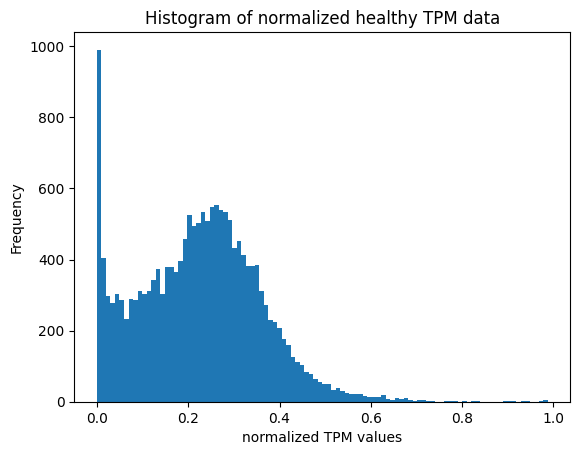

In [8]:
# norm healthy tpm
plt.hist(df_nodes_genes['norm healthy TPM'], bins=100)
plt.title('Histogram of normalized healthy TPM data')
plt.xlabel('normalized TPM values')
plt.ylabel('Frequency')

plt.savefig('../tex/figures/03_02_normalized_gtex_tpm.png')
plt.show()

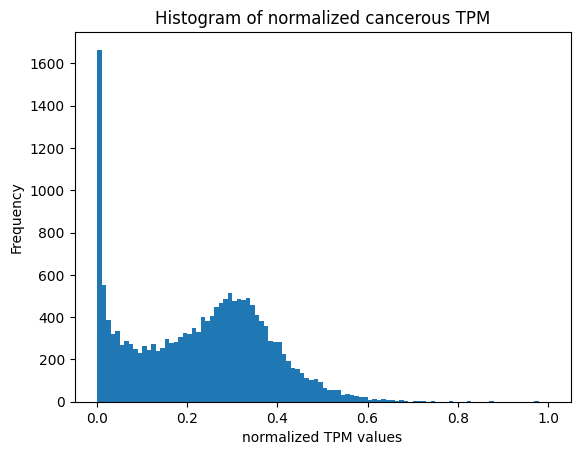

In [9]:
# norm cmp tpm
plt.hist(df_nodes_genes['norm cancerous TPM'], bins=100)
plt.title('Histogram of normalized cancerous TPM')
plt.xlabel('normalized TPM values')
plt.ylabel('Frequency')

plt.savefig('../tex/figures/03_02_normalized_cmp_tpm.png')
plt.show()

In [10]:
df_nodes_genes.drop(columns=['healthy TPM', 'cancerous TPM'], inplace=True)
df_nodes_genes

,Gene ID,Gene Name,norm healthy TPM,norm cancerous TPM
0,ENSG00000121410,A1BG,0.220900,0.056729
2,ENSG00000148584,A1CF,0.057012,0.080626
3,ENSG00000175899,A2M,0.579917,0.092398
5,ENSG00000166535,A2ML1,0.332704,0.062953
8,ENSG00000184389,A3GALT2,0.021656,0.046758
...,...,...,...,...
32858,ENSG00000070476,ZXDC,0.270354,0.289125
32859,ENSG00000203995,ZYG11A,0.039046,0.219098
32861,ENSG00000162378,ZYG11B,0.252818,0.291435
32863,ENSG00000074755,ZZEF1,0.280583,0.275600


## Calculate `Δ tpm`

value of the difference between the normalized cancerous tpm and normalized healthy tpm

In [11]:
df_nodes_genes['Δ TPM'] = df_nodes_genes['norm cancerous TPM'] - df_nodes_genes['norm healthy TPM']
df_nodes_genes['Δ type'] = np.where(df_nodes_genes['Δ TPM'] > 0, 'increase', 'decrease')

df_nodes_genes

,Gene ID,Gene Name,norm healthy TPM,norm cancerous TPM,Δ TPM,Δ type
0,ENSG00000121410,A1BG,0.220900,0.056729,-0.164171,decrease
2,ENSG00000148584,A1CF,0.057012,0.080626,0.023614,increase
3,ENSG00000175899,A2M,0.579917,0.092398,-0.487519,decrease
5,ENSG00000166535,A2ML1,0.332704,0.062953,-0.269751,decrease
8,ENSG00000184389,A3GALT2,0.021656,0.046758,0.025101,increase
...,...,...,...,...,...,...
32858,ENSG00000070476,ZXDC,0.270354,0.289125,0.018771,increase
32859,ENSG00000203995,ZYG11A,0.039046,0.219098,0.180052,increase
32861,ENSG00000162378,ZYG11B,0.252818,0.291435,0.038617,increase
32863,ENSG00000074755,ZZEF1,0.280583,0.275600,-0.004983,decrease


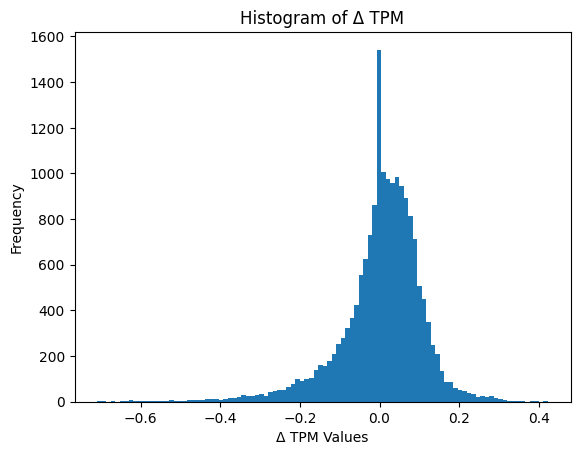

In [12]:
plt.hist(df_nodes_genes['Δ TPM'], bins=100)
plt.title('Histogram of Δ TPM')
plt.xlabel('Δ TPM Values')
plt.ylabel('Frequency')

plt.savefig('../tex/figures/03_02_delta_tpm.png')
plt.show()

## Calculate `Δ TPM relevant` with z score
Add a column that indicates if the change in the gene activity is relevant between cancer and healthy tissue.


Z Score of the Δ TPM values is calculated and used to determine if the gene is relevant for cancer.
This z score means how many standard deviations the Δ tpm value is away from the mean.


In [13]:
df_nodes_genes['z score'] = zscore(df_nodes_genes['Δ TPM'])

# 1.96 for the highest 5% and the lowest 5% of the normal distribution
z_threshold = 1.96
df_nodes_genes['Δ TPM relevant'] = df_nodes_genes['z score'].abs() > z_threshold

df_nodes_genes

,Gene ID,Gene Name,norm healthy TPM,norm cancerous TPM,Δ TPM,Δ type,z score,Δ TPM relevant
0,ENSG00000121410,A1BG,0.220900,0.056729,-0.164171,decrease,-1.613031,False
2,ENSG00000148584,A1CF,0.057012,0.080626,0.023614,increase,0.183172,False
3,ENSG00000175899,A2M,0.579917,0.092398,-0.487519,decrease,-4.705922,True
5,ENSG00000166535,A2ML1,0.332704,0.062953,-0.269751,decrease,-2.622919,True
8,ENSG00000184389,A3GALT2,0.021656,0.046758,0.025101,increase,0.197398,False
...,...,...,...,...,...,...,...,...
32858,ENSG00000070476,ZXDC,0.270354,0.289125,0.018771,increase,0.136848,False
32859,ENSG00000203995,ZYG11A,0.039046,0.219098,0.180052,increase,1.679534,False
32861,ENSG00000162378,ZYG11B,0.252818,0.291435,0.038617,increase,0.326676,False
32863,ENSG00000074755,ZZEF1,0.280583,0.275600,-0.004983,decrease,-0.090362,False


In [14]:
print("There are {} genes that have a significant change in gene activity.".format(df_nodes_genes['Δ TPM relevant'].sum()))

There are 1034 genes that have a significant change in gene activity.


## Save

In [15]:
df_nodes_genes.to_csv('../processed_data/nodes_genes.csv', index=False)

In [16]:
print(f"There are {df_nodes_genes.shape[0]} rows as gene nodes.")

There are 17626 rows as gene nodes.


In [17]:
import dataframe_image as dfi
df_nodes_genes_plot = df_nodes_genes.copy()
df_nodes_genes_plot = df_nodes_genes_plot.reset_index(drop=True)

dfi.export(df_nodes_genes_plot.head(5), '../tex/figures/03_02_gene_nodes.png')